<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 5.  Соревнование Kaggle "Identify Me If You Can"

На этой неделе мы вспомним про концепцию стохастического градиентного спуска и опробуем классификатор Scikit-learn SGDClassifier, который работает намного быстрее на больших выборках, чем алгоритмы, которые мы тестировали на 4 неделе. Также мы познакомимся с данными [соревнования](https://inclass.kaggle.com/c/identify-me-if-you-can4) Kaggle по идентификации пользователей и сделаем в нем первые посылки. По итогам этой недели дополнительные баллы получат те, кто попадет в топ-30 публичного лидерборда соревнования.

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Стохатический градиентный спуск](https://www.coursera.org/learn/supervised-learning/lecture/xRY50/stokhastichieskii-ghradiientnyi-spusk)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   
**Также рекомендуется вернуться и просмотреть [задание](https://www.coursera.org/learn/supervised-learning/programming/t2Idc/linieinaia-rieghriessiia-i-stokhastichieskii-ghradiientnyi-spusk) "Линейная регрессия и стохастический градиентный спуск" 1 недели 2 курса специализации.**

In [94]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from tqdm import tqdm

**Считаем данные [соревнования](https://inclass.kaggle.com/c/identify-me-if-you-can4/data) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [95]:
# Поменяйте на свой путь к данным
#PATH_TO_DATA = 'C:\Users\ABT\Data and ML\Course_VI\Identify_Kaggle' 
PATH_TO_DATA = './'

In [96]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [97]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,user_id
session_id,,,,,,,,,,,,,,,,,,,,,
1,23713,2014-03-24 15:22:40,23720.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:54,23720.0,2014-03-24 15:22:54,...,2014-03-24 15:22:55,23713.0,2014-03-24 15:23:01,23713.0,2014-03-24 15:23:03,23713.0,2014-03-24 15:23:04,23713.0,2014-03-24 15:23:05,653
2,8726,2014-04-17 14:25:58,8725.0,2014-04-17 14:25:59,665.0,2014-04-17 14:25:59,8727.0,2014-04-17 14:25:59,45.0,2014-04-17 14:25:59,...,2014-04-17 14:26:01,45.0,2014-04-17 14:26:01,5320.0,2014-04-17 14:26:18,5320.0,2014-04-17 14:26:47,5320.0,2014-04-17 14:26:48,198
3,303,2014-03-21 10:12:24,19.0,2014-03-21 10:12:36,303.0,2014-03-21 10:12:54,303.0,2014-03-21 10:13:01,303.0,2014-03-21 10:13:24,...,2014-03-21 10:13:36,303.0,2014-03-21 10:13:54,309.0,2014-03-21 10:14:01,303.0,2014-03-21 10:14:06,303.0,2014-03-21 10:14:24,34
4,1359,2013-12-13 09:52:28,925.0,2013-12-13 09:54:34,1240.0,2013-12-13 09:54:34,1360.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:54:34,...,2013-12-13 09:54:34,1346.0,2013-12-13 09:54:34,1345.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:58:19,1345.0,2013-12-13 09:58:19,601
5,11,2013-11-26 12:35:29,85.0,2013-11-26 12:35:31,52.0,2013-11-26 12:35:31,85.0,2013-11-26 12:35:32,11.0,2013-11-26 12:35:32,...,2013-11-26 12:35:32,11.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:03,10.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:04,273


**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.**

In [98]:
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длиннее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

In [99]:
train_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229266 entries, 1 to 46473
Data columns (total 21 columns):
site1      229266 non-null int64
site10     213789 non-null float64
site2      227223 non-null float64
site3      225084 non-null float64
site4      223375 non-null float64
site5      221638 non-null float64
site6      219955 non-null float64
site7      218361 non-null float64
site8      216846 non-null float64
site9      215265 non-null float64
time1      229266 non-null object
time10     213789 non-null object
time2      227223 non-null object
time3      225084 non-null object
time4      223375 non-null object
time5      221638 non-null object
time6      219955 non-null object
time7      218361 non-null object
time8      216846 non-null object
time9      215265 non-null object
user_id    182793 non-null float64
dtypes: float64(10), int64(1), object(10)
memory usage: 38.5+ MB


**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [100]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182793 entries, 1 to 182793
Data columns (total 21 columns):
site1      182793 non-null int64
time1      182793 non-null object
site2      181175 non-null float64
time2      181175 non-null object
site3      179441 non-null float64
time3      179441 non-null object
site4      178054 non-null float64
time4      178054 non-null object
site5      176653 non-null float64
time5      176653 non-null object
site6      175268 non-null float64
time6      175268 non-null object
site7      173960 non-null float64
time7      173960 non-null object
site8      172738 non-null float64
time8      172738 non-null object
site9      171437 non-null float64
time9      171437 non-null object
site10     170247 non-null float64
time10     170247 non-null object
user_id    182793 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 30.7+ MB


In [101]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,user_id
session_id,,,,,,,,,,,,,,,,,,,,,
1,23713,2014-03-24 15:22:40,23720.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:54,23720.0,2014-03-24 15:22:54,...,2014-03-24 15:22:55,23713.0,2014-03-24 15:23:01,23713.0,2014-03-24 15:23:03,23713.0,2014-03-24 15:23:04,23713.0,2014-03-24 15:23:05,653
2,8726,2014-04-17 14:25:58,8725.0,2014-04-17 14:25:59,665.0,2014-04-17 14:25:59,8727.0,2014-04-17 14:25:59,45.0,2014-04-17 14:25:59,...,2014-04-17 14:26:01,45.0,2014-04-17 14:26:01,5320.0,2014-04-17 14:26:18,5320.0,2014-04-17 14:26:47,5320.0,2014-04-17 14:26:48,198
3,303,2014-03-21 10:12:24,19.0,2014-03-21 10:12:36,303.0,2014-03-21 10:12:54,303.0,2014-03-21 10:13:01,303.0,2014-03-21 10:13:24,...,2014-03-21 10:13:36,303.0,2014-03-21 10:13:54,309.0,2014-03-21 10:14:01,303.0,2014-03-21 10:14:06,303.0,2014-03-21 10:14:24,34
4,1359,2013-12-13 09:52:28,925.0,2013-12-13 09:54:34,1240.0,2013-12-13 09:54:34,1360.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:54:34,...,2013-12-13 09:54:34,1346.0,2013-12-13 09:54:34,1345.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:58:19,1345.0,2013-12-13 09:58:19,601
5,11,2013-11-26 12:35:29,85.0,2013-11-26 12:35:31,52.0,2013-11-26 12:35:31,85.0,2013-11-26 12:35:32,11.0,2013-11-26 12:35:32,...,2013-11-26 12:35:32,11.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:03,10.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:04,273


In [102]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46473 entries, 1 to 46473
Data columns (total 20 columns):
site1     46473 non-null int64
time1     46473 non-null object
site2     46048 non-null float64
time2     46048 non-null object
site3     45643 non-null float64
time3     45643 non-null object
site4     45321 non-null float64
time4     45321 non-null object
site5     44985 non-null float64
time5     44985 non-null object
site6     44687 non-null float64
time6     44687 non-null object
site7     44401 non-null float64
time7     44401 non-null object
site8     44108 non-null float64
time8     44108 non-null object
site9     43828 non-null float64
time9     43828 non-null object
site10    43542 non-null float64
time10    43542 non-null object
dtypes: float64(9), int64(1), object(10)
memory usage: 7.4+ MB


**В обучающей выборке – 400 пользователей.**

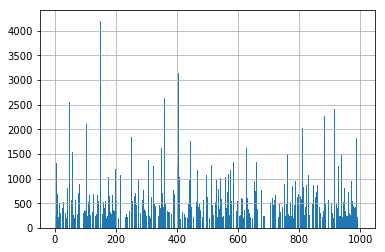

In [91]:
train_df['user_id'].hist(bins=400)

**Пока для прогноза ID пользователя будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [103]:
train_test_df_sites = train_test_df[['site1', 'site2', 'site3', 
                                     'site4','site5', 
                                     'site6','site7', 'site8', 
                                     'site9', 'site10']].fillna(0).astype('int')

In [104]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,23713,23720,23713,23713,23720,23713,23713,23713,23713,23713
2,8726,8725,665,8727,45,8725,45,5320,5320,5320
3,303,19,303,303,303,303,303,309,303,303
4,1359,925,1240,1360,1344,1359,1346,1345,1344,1345
5,11,85,52,85,11,52,11,85,10,85
6,83,1344,1240,1359,1345,85,1346,83,925,1359
7,13585,13585,13585,13585,13585,13585,13585,13585,13586,13585
8,29312,29311,29312,29312,0,0,0,0,0,0
9,21,62,18,1387,7,72,1386,1384,10,22


**Создайте разреженные матрицы *X_train_sparse* и *X_test_sparse* аналогично тому, как мы это делали ранее. Используйте объединенную матрицу *train_test_df_sites*, потом разделите обратно на обучающую и тестовую части.**

Обратите внимание на то, что в  сессиях меньше 10 сайтов  у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы надо будет удалить.

**Выделите в отдельный вектор *y* ответы на обучающей выборке.**

In [112]:
def prepear_csr(X):
    indices_csr=[]
    indptr=[0]
    for sess in X:
        #убираем 0 из сессий
        if 0. in sess:
            sess=sess[:list(sess).index(0.)]
        indices_csr.extend(map(int,sess))
        indptr.append(len(indices_csr))
    data_csr=list([1]*len(indices_csr))
    #индексы должны начинаться с 0, поэтому все уменьшаем на 1
    indices_csr=[ind-1 for ind in indices_csr]
    return (data_csr, indices_csr, indptr)

In [113]:
X_ = train_test_df_sites.values
X_.shape

(229266, 10)

In [114]:
train_test_df_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,23713,23720,23713,23713,23720,23713,23713,23713,23713,23713
2,8726,8725,665,8727,45,8725,45,5320,5320,5320
3,303,19,303,303,303,303,303,309,303,303
4,1359,925,1240,1360,1344,1359,1346,1345,1344,1345
5,11,85,52,85,11,52,11,85,10,85


In [115]:
train_df.shape, test_df.shape

((182793, 21), (46473, 20))

In [116]:
X_ = train_test_df_sites.values
X_train_test_sparse = csr_matrix(prepear_csr(X_),dtype=int)
X_train_sparse = X_train_test_sparse[:train_df.shape[0]]
X_test_sparse = X_train_test_sparse[-test_df.shape[0]:]

y=train_df.iloc[:, -1].values

**1. Выведите размерности матриц *X_train_sparse* и *X_test_sparse* – 4 числа на одной строке через пробел: число строк и столбцов матрицы *X_train_sparse*, затем число строк и столбцов матрицы *X_test_sparse*.**

In [117]:
print ('{} {} {} {}'.format(X_train_sparse.shape[0],X_train_sparse.shape[1],X_test_sparse.shape[0],X_test_sparse.shape[1] ))

182793 36656 46473 36656


**Сохраним в pickle-файлы объекты *X_train_sparse*, *X_test_sparse* и *y* (последний – в файл *train_target.pkl*).**

In [121]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

**Разобьем обучающую выборку на 2 части в пропорции 7/3.**

In [122]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y, test_size=0.3, 
                                                     random_state=17, stratify=y)

**Создайте объекты `sklearn.linear_model.SGDClassifier` с логистической функцией потерь и с *hinge loss* (логистическая регрессия и линейный SVM соответственно) и параметром `random_state`=17. Остальные параметры оставьте по умолчанию, разве что `n_jobs`=-1 никогда не помешает. Обучите  модели на выборке `(X_train, y_train)`.**

In [123]:
sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)

In [124]:
%%time
sgd_logit.fit(X_train, y_train)

CPU times: user 60 s, sys: 18.8 s, total: 1min 18s
Wall time: 20.8 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=17, shuffle=True, verbose=0,
       warm_start=False)

In [125]:
sgd_svm = SGDClassifier(loss='hinge', random_state=17, n_jobs=-1)

In [126]:
%%time
sgd_svm.fit(X_train, y_train)

CPU times: user 43.3 s, sys: 18.2 s, total: 1min 1s
Wall time: 16 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=17, shuffle=True, verbose=0,
       warm_start=False)

**Сделаем прогнозы с помощью обеих моделей на отложенной выборке *(X_valid, y_valid)*.**

In [127]:
logit_valid_pred = sgd_logit.predict(X_valid)
svm_valid_pred = sgd_svm.predict(X_valid)

**2. Напечатайте через пробел доли правильных ответов логистической регрессии и линейного SVM, обученных с помощью стохастического градиентного спуска, на отложенной выборке. Округлите до 3 знаков после разделителя.**

In [128]:
print (round(accuracy_score(y_valid,logit_valid_pred ),3),' ', round(accuracy_score(y_valid,svm_valid_pred ),3))

0.302   0.295


**Сделайте прогноз для тестовой выборки с помощью *sgd_logit*.**

In [129]:
logit_test_pred = sgd_logit.predict(X_test_sparse)

**Запишите ответы в файл и сделайте посылку на Kaggle. Далее дайте своей команде (из одного человека) на Kaggle говорящее название – по шаблону "[YDF & MIPT] _Username", чтоб можно было легко идентифицировать Вашу посылку на [лидерборде](https://inclass.kaggle.com/c/identify-me-if-you-can4/leaderboard).**

**Результат, который мы только что получили, соответствует бейзлайну "SGDCLassifer" на лидерборде, задача на эту неделю – как минимум его побить, дополнительные баллы будут для тех, кто попадет в топ-10 и топ-30 по итогам этой недели.**

In [74]:
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [130]:
write_to_submission_file(logit_test_pred, 'logit_test_pred_v0')

### на Kaggle лидерборд
## #9 	↑16 [YDF & MIPT] _abt 0.19892 	12 	Sat, 24 Jun 2017 15:06:01 

## Критерии оценки работы:
-  Правильные ли получились размерности матриц в п. 1? (max. 2 балла)
-  Правильные ли получились доли правильных ответов логистической регрессии и линейного SVM в п . 2? (max. 4 балла)
-  Каков результат лучшей из посылок на Kaggle, побит ли бейзлайн SGDCLassifier?  (max. 2 балла)
-  Входит ли  посылка в топ-30 лучших на данный момент на публичном лидерборде соревнования? (max. 2 балла)
-  Входит ли  посылка в топ-10 лучших на данный момент на публичном лидерборде соревнования? (max. 4 балла)

## Пути улучшения
На этой неделе дается много времени на соревнование. Не забывайте вносить хорошие идеи, к которым Вы пришли по ходу соревнования, в описание финального проекта (`html`, `pdf` или `ipynb`).
Что можно попробовать:
 - Использовать ранее построенные признаки для улучшения модели (проверить их можно на меньшей выборке по 150 пользователям – это быстрее)
 - Настроить параметры моделей (например, коэффициенты регуляризации)
 - Если позволяют мощности (или хватает терпения), можно попробовать смешивание (блендинг) ответов бустинга и линейной модели. [Вот](http://mlwave.com/kaggle-ensembling-guide/) один из самых известных тьюториалов по смешиванию ответов алгоритмов
 - Обратите внимание, что в соревновании также даны исходные данные о посещенных 400 пользователями веб-страницах (400 csv-файлов в *train.zip*). По этим данным можно сформировать свою обучающую выборку. 

На 6 неделе мы пройдем большой тьюториал по Vowpal Wabbit и попробуем его в деле, на данных соревнования.